In [119]:
import numpy as np
import matplotlib.pyplot as plt
import os
from adabox import proc
from adabox.plot_tools import plot_rectangles, plot_rectangles_only_lines

In [120]:
# Parameters
name_room = 'room_with_obstacles'

len_x_meters = 80
len_y_meters = 80
len_z_meters = 20

# Define the number of rows and columns for the grid
num_rows = 80
num_cols = int(num_rows/len_y_meters*len_x_meters)

# Define a threshold value
threshold = 0.5

# Number of random searches, more is better!
searches = 10

In [121]:
# Input Path
in_path = os.getcwd() + '/data/' + name_room + '.png'

# Output Path
out_path = os.getcwd() + '/data/' + name_room + '.txt'

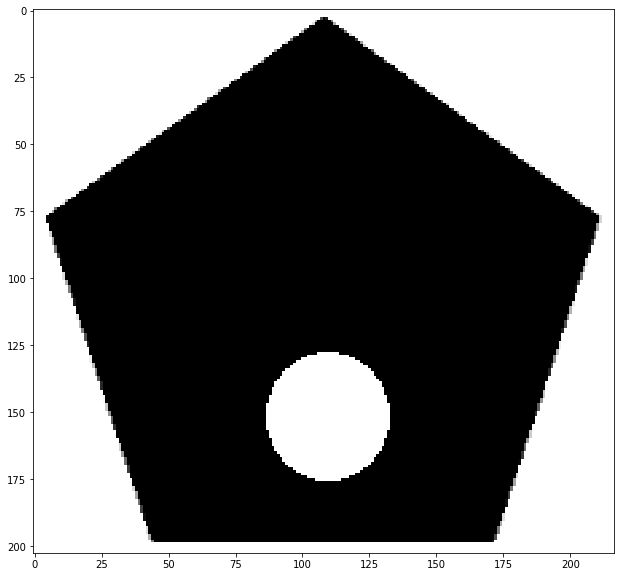

In [122]:
# Load the image
image = plt.imread(in_path)

# Convert the image to grayscale
image = np.mean(image, axis=2)

# Plot the image
plt.figure(figsize=(20, 10))
plt.imshow(image, cmap='gray')

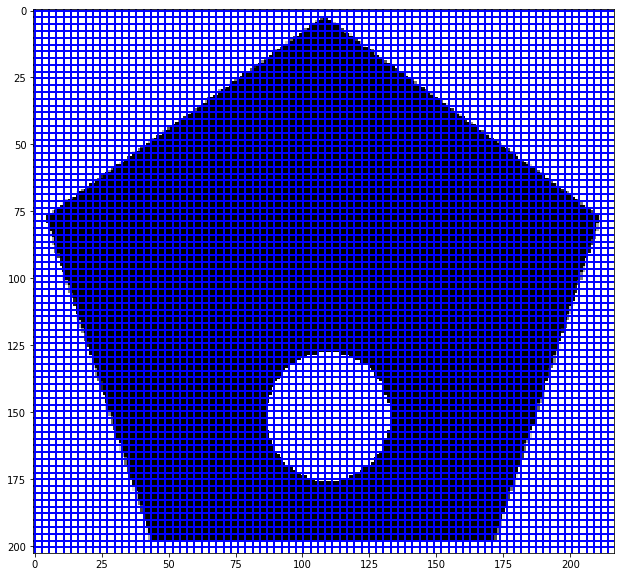

In [123]:
# Calculate the size of each block in terms of image dimensions
block_height = image.shape[0] / num_rows
block_width = image.shape[1] / num_cols

# Create a scatter plot using Matplotlib for the grid
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.imshow(image, cmap='gray')

# Superimpose a red grid with thicker and solid lines
for row in range(num_rows):
    plt.axhline(row * block_height, color='blue', linestyle='-', linewidth=2)
for col in range(num_cols):
    plt.axvline(col * block_width, color='blue', linestyle='-', linewidth=2)

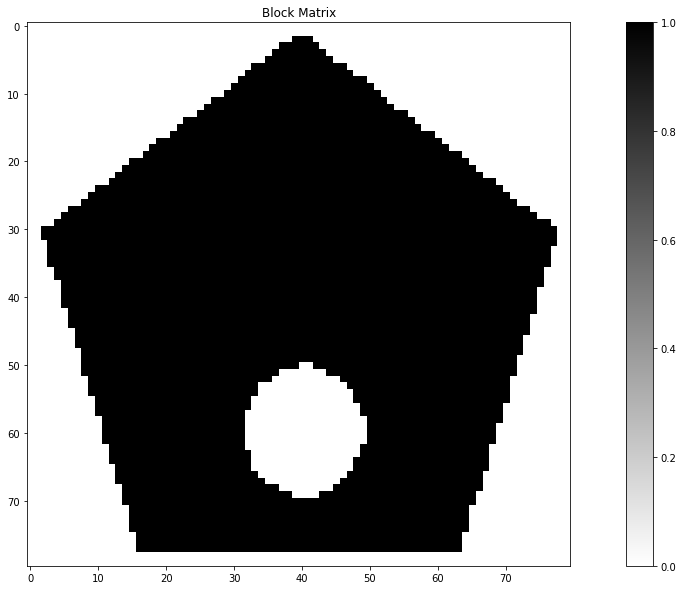

In [124]:
# Initialize the 2D matrix to store block information (all zeros for empty)
block_matrix = np.zeros((num_rows, num_cols), dtype=int)

# Superimpose a red grid with thicker and solid lines
for row in range(num_rows):
    for col in range(num_cols):

        # Calculate the coordinates for the block in the image
        block_x_start = int(col * block_width)
        block_x_end = int((col + 1) * block_width)
        block_y_start = int(row * block_height)
        block_y_end = int((row + 1) * block_height)

        # Extract the corresponding block from the image
        block = image[block_y_start:block_y_end, block_x_start:block_x_end]

        # Check if the average pixel value of the block is above the threshold
        if np.mean(block) < threshold:
            block_matrix[row, col] = 1  # Mark the block as full
            
# Plot the 2D matrix
plt.figure(figsize=(20, 10))
plt.imshow(block_matrix, cmap='binary', interpolation='nearest', origin='upper')
plt.title('Block Matrix')
plt.colorbar()

plt.show()

In [125]:
flag = 0.0

block_height_meters = len_y_meters / num_rows
block_width_meters = len_x_meters / num_cols

# Assuming you already have the 'block_matrix'
# Create a list to store the [x_position, y_position] for each row
block_info_list = []

# Loop through each row and column in 'block_matrix'
for row in range(num_rows):
    for col in range(num_cols):
        # Calculate the x and y positions
        x_position = col * block_width_meters + block_width_meters/2
        y_position = row * block_height_meters + block_height_meters/2

        if block_matrix[row, col] == 1:
            # Append the [x_position, y_position] to the list
            block_info_list.append([x_position, y_position, flag])

# Convert the list to a NumPy array
data_2d = np.array(block_info_list)

# 'block_info_matrix' contains [x_position, y_position, flag] for each block

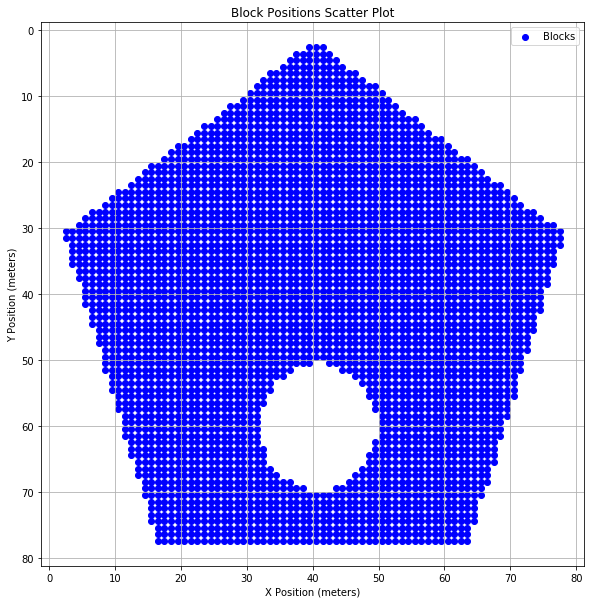

In [126]:
# Extract x and y positions from the block_info_matrix
x_positions = data_2d[:, 0]
y_positions = data_2d[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(x_positions, y_positions, c='b', marker='o', label='Blocks')
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.title('Block Positions Scatter Plot')
plt.grid(True)
plt.legend()
plt.axis('scaled')
plt.gca().invert_yaxis()  # Invert the y-axis

# Display the plot
plt.show()

In [127]:
rectangles = []

(rectangles, sep_value) = proc.decompose(data_2d, searches)
print('Number of rectangles found: ' + str(len(rectangles)))
print('Separating value: ' + str(sep_value))

Using 12 process(threads) and 10 searches per step
Number of rectangles found: 104
Separating value: 1.0


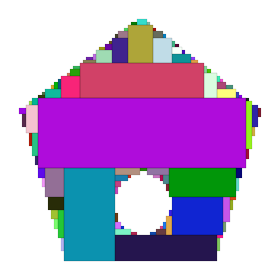

In [128]:
plot_rectangles(rectangles, sep_value)
plt.gca().invert_yaxis()  # Invert the y-axis

In [129]:
sep_to_plot = sep_value / 2

# Initialize an empty list to store the rectangle coordinates
rectangle_coordinates = []

for rectangle in rectangles:
    p1 = np.array([rectangle.x1 - sep_to_plot, rectangle.y1 - sep_to_plot])
    p2 = np.array([rectangle.x1 - sep_to_plot, rectangle.y2 + sep_to_plot])
    p3 = np.array([rectangle.x2 + sep_to_plot, rectangle.y1 - sep_to_plot])
    p4 = np.array([rectangle.x2 + sep_to_plot, rectangle.y2 + sep_to_plot])
    
    rectangle_coordinates.append([p1, p2, p3, p4])

# Convert the list of rectangle coordinates to a 2D NumPy array
data = np.array(rectangle_coordinates).reshape(-1, 8)  # Flatten the list to a 2D array with 8 columns

In [130]:
# Extract coordinates
bottom_left_x = data[:, 0]
bottom_left_y = data[:, 1]
up_left_x = data[:, 2]
up_left_y = data[:, 3]
bottom_right_x = data[:, 4]
bottom_right_y = data[:, 5]
up_right_x = data[:, 6]
up_right_y = data[:, 7]

In [131]:
# Compute width and height
width = bottom_right_x - bottom_left_x
height = up_left_y - bottom_left_y

In [132]:
zeros_col = np.zeros(width.shape)
depth_col = len_z_meters*np.ones(width.shape)

In [133]:
# Create a new data array with left bottom x, left bottom y, width, and height
new_data = np.column_stack((bottom_left_x, bottom_left_y, zeros_col, width, height, depth_col))

In [134]:
# Save the processed data to a new CSV text file
np.savetxt(out_path, new_data, delimiter=' ', fmt='%0.2f')